![](https://www.dii.uchile.cl/wp-content/uploads/2021/06/Magi%CC%81ster-en-Ciencia-de-Datos.png)

# Proyecto: Riesgo en el Banco Giturra

**MDS7202: Laboratorio de Programación Científica para Ciencia de Datos**

### Cuerpo Docente:

- Profesor: Pablo Badilla, Ignacio Meza De La Jara
- Auxiliar: Sebastián Tinoco
- Ayudante: Diego Cortez M., Felipe Arias T.

### Equipo:

- Nombre de alumno 1: Felipe Méndez 
- Nombre de alumno 2: Luis Figueroa

## Introducción


El presente informe tiene como objetivo desarrollar un algoritmo utilizando técnicas de machine learning para predecir clientes fraudulentos en el contexto del banco de Giturra. Ante la creciente cantidad de préstamos impagados y la necesidad de mejorar la calidad de los préstamos otorgados, Giturra reconoce la importancia de reducir los riesgos de préstamo y busca aprovechar la ciencia de datos y el análisis de riesgo crediticio para lograrlo.

El problema planteado consiste en predecir la probabilidad de incumplimiento de pago de los clientes, utilizando una amplia gama de variables proporcionadas por el banco, como historiales de crédito, ingresos y otros factores financieros relevantes. El objetivo es proporcionar a Giturra decisiones más informadas en cuanto a los préstamos, permitiéndole ofrecer condiciones más favorables a aquellos con menor riesgo de impago.

Los datos de entrada provistos por el banco incluyen una variedad de características de los clientes, que se utilizarán para construir y entrenar los modelos predictivos. Estas características abarcan información relevante como historiales de crédito, ingresos, y otros indicadores financieros, que permitirán establecer patrones y relaciones para la predicción del riesgo crediticio.

Para evaluar los modelos generados, se utilizará la métrica F1 score, que combina la precisión y el recall en una sola medida. Dado que los datos presentan un desbalanceo entre las clases de clientes fraudulentos y no fraudulentos, el uso de la métrica 'accuracy' sería inapropiado, ya que puede dar lugar a resultados engañosos en este tipo de escenarios. En cambio, la métrica F1 score proporciona una evaluación más equilibrada al considerar tanto los falsos positivos como los falsos negativos. Al enfocarnos en esta métrica, podremos evaluar adecuadamente el rendimiento del modelo en la tarea de identificar clientes fraudulentos y justificar las decisiones de préstamo en base a dicha evaluación.

Para abordar el problema de predicción de clientes fraudulentos, se utilizaron dos modelos: un clasificador SVM (Support Vector Machine) implementado a través del algoritmo SVC (Support Vector Classifier) y un clasificador de LightGBM (Light Gradient Boosting Machine). Previamente al entrenamiento de los modelos, se realizó un proceso de limpieza de los datos, el cual incluyó la eliminación de valores nulos y registros con información inconsistente. Además, se crearon nuevas variables, como el ratio entre los ingresos y la deuda, para capturar relaciones relevantes en los datos. Asimismo, se aplicaron técnicas de escalamiento y one-hot encoding para asegurar la adecuada representación de las variables en los modelos. Para abordar el desbalanceo entre las clases de clientes fraudulentos y no fraudulentos, se implementó una técnica de muestreo aleatorio llamada Random Over Sampling, que generó réplicas de la clase minoritaria. Estas acciones en el preprocesamiento de los datos permitieron mejorar el desempeño de los modelos y su capacidad para detectar correctamente los clientes fraudulentos.

Logramos resolver el problema a través de nuestro modelo predictivo de riesgo crediticio. Los resultados de nuestro mejor modelo (LGBMClassifier), con un F1 score de 0.6426, son aceptables y representan una mejora significativa respecto al baseline. Sin embargo, reconocemos que siempre hay margen para seguir mejorando y explorar otras alternativas de modelado para obtener resultados aún más sólidos. Desconocemos que métricas obtuvieron el resto de los grupos.

## Carga y EDA

In [29]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import seaborn as sns
import random
import time 
import shap

import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import f1_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
import warnings
import logging


import optuna

#os.chdir(r'C:\Users\luish\OneDrive - Universidad de Chile\Universidad de Chile - FCFM\XI Semestre\MDS7202 - Laboratorio de Programacion Cientifica para Ciencia de Datos\Proyectos\Proyecto 2')
os.chdir(r'/Users/felipemendez/Desktop/Universidad/11vo_semestre/Lab/Proyecto_2')
pd.set_option('display.max_columns', None)

seed = 42

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

set_seed(seed)

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
lgb_logger = logging.getLogger('lightgbm')
lgb_logger.setLevel(logging.CRITICAL)

In [2]:
def exploratory_data_analysis(dataframe):
    dataframe = dataframe.copy()
    print(f'El DataFrame tiene {dataframe.shape[0]} filas y {dataframe.shape[1]} columnas','\n')
    print('Muestreo aleatorio de 5 filas:')
    display(dataframe.sample(5))
    print(' Descripción numérica del Dataframe:')
    display(dataframe.describe())
    print(' Cantidad de valores nulos por columna:','\n')
    print(dataframe.isna().sum(),'\n')
    print(' Cantidad de valores únicos por columna:','\n')
    print(dataframe.nunique(),'\n')

    pass   




data = pd.read_parquet('dataset.pq')

exploratory_data_analysis(data)

El DataFrame tiene 12500 filas y 22 columnas 

Muestreo aleatorio de 5 filas:


,customer_id,age,occupation,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
1766,CUS_0xc70d,17.0,Scientist,17910.36,1521.530000,5,7,15,6.0,21,8.0,8.13,10.0,2577.05,38.164413,10.0,Yes,59.674447,NaN,Low_spent_Small_value_payments,203.020395,1
11919,CUS_0x1ad3,35.0,Scientist,14231.96,1200.230050,8,5,18,5.0,41,25.0,10.47,10.0,2465.39,28.315783,10.0,Yes,167.533353,12.812416,High_spent_Large_value_payments,305.920514,0
8909,CUS_0x583c,32.0,Accountant,31696.73,2363.394167,3,6,15,0.0,26,12.0,10.40,7.0,1055.29,26.952421,21.0,No,0.000000,47.821221,High_spent_Medium_value_payments,438.518196,0
4963,CUS_0x7423,52.0,Musician,42274.96,3284.913333,3,7,1,0.0,12,8.0,11.79,2.0,703.05,38.681581,31.0,No,0.000000,226.944303,Low_spent_Medium_value_payments,381.547030,0
10099,CUS_0x396d,32.0,Manager,33032.46,NaN,8,7,20,-100.0,24,9.0,8.68,8.0,891.29,38.467155,15.0,Yes,35.275234,32.217876,High_spent_Large_value_payments,456.777390,0


 Descripción numérica del Dataframe:


,age,annual_income,monthly_inhand_salary,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,total_emi_per_month,amount_invested_monthly,monthly_balance,credit_score
count,12500.000000,1.250000e+04,10584.000000,12500.000000,12500.000000,12500.000000,12500.000000,12500.000000,11660.00000,12246.000000,12243.000000,12500.000000,12500.000000,11380.000000,12500.000000,11914.000000,1.214500e+04,12500.000000
mean,105.771840,1.616206e+05,4186.634963,16.939920,23.172720,73.213360,3.099440,21.060880,32.93542,10.398582,26.292330,1426.220376,32.349265,18.230404,1488.394291,638.798715,-2.744614e+22,0.288160
std,664.502705,1.297842e+06,3173.690362,114.350815,132.005866,468.682227,65.105277,14.863091,237.43768,6.799253,181.821031,1155.169458,5.156815,8.302078,8561.449910,2049.195193,3.024684e+24,0.452924
min,-500.000000,7.005930e+03,303.645417,-1.000000,0.000000,1.000000,-100.000000,-5.000000,-3.00000,-6.490000,0.000000,0.230000,20.100770,0.000000,0.000000,0.000000,-3.333333e+26,0.000000
25%,25.000000,1.945333e+04,1622.408646,3.000000,4.000000,8.000000,1.000000,10.000000,9.00000,5.370000,4.000000,566.072500,28.066517,12.000000,31.496968,73.736810,2.701501e+02,0.000000
50%,33.000000,3.757238e+04,3087.595000,6.000000,5.000000,14.000000,3.000000,18.000000,14.00000,9.410000,6.000000,1166.155000,32.418953,18.000000,72.887628,134.093193,3.393885e+02,0.000000
75%,42.000000,7.269021e+04,5967.937500,7.000000,7.000000,20.000000,5.000000,28.000000,18.00000,14.940000,10.000000,1945.962500,36.623650,25.000000,169.634826,261.664256,4.714245e+02,1.000000
max,8678.000000,2.383470e+07,15204.633333,1756.000000,1499.000000,5789.000000,1495.000000,67.000000,4293.00000,36.970000,2554.000000,4998.070000,48.199824,33.000000,81971.000000,10000.000000,1.463792e+03,1.000000


 Cantidad de valores nulos por columna: 

customer_id                    0
age                            0
occupation                     0
annual_income                  0
monthly_inhand_salary       1916
num_bank_accounts              0
num_credit_card                0
interest_rate                  0
num_of_loan                    0
delay_from_due_date            0
num_of_delayed_payment       840
changed_credit_limit         254
num_credit_inquiries         257
outstanding_debt               0
credit_utilization_ratio       0
credit_history_age          1120
payment_of_min_amount          0
total_emi_per_month            0
amount_invested_monthly      586
payment_behaviour              0
monthly_balance              355
credit_score                   0
dtype: int64 

 Cantidad de valores únicos por columna: 

customer_id                 12500
age                           258
occupation                     16
annual_income               12489
monthly_inhand_salary       10579
num_

### Análisis Exploratorio de los Datos

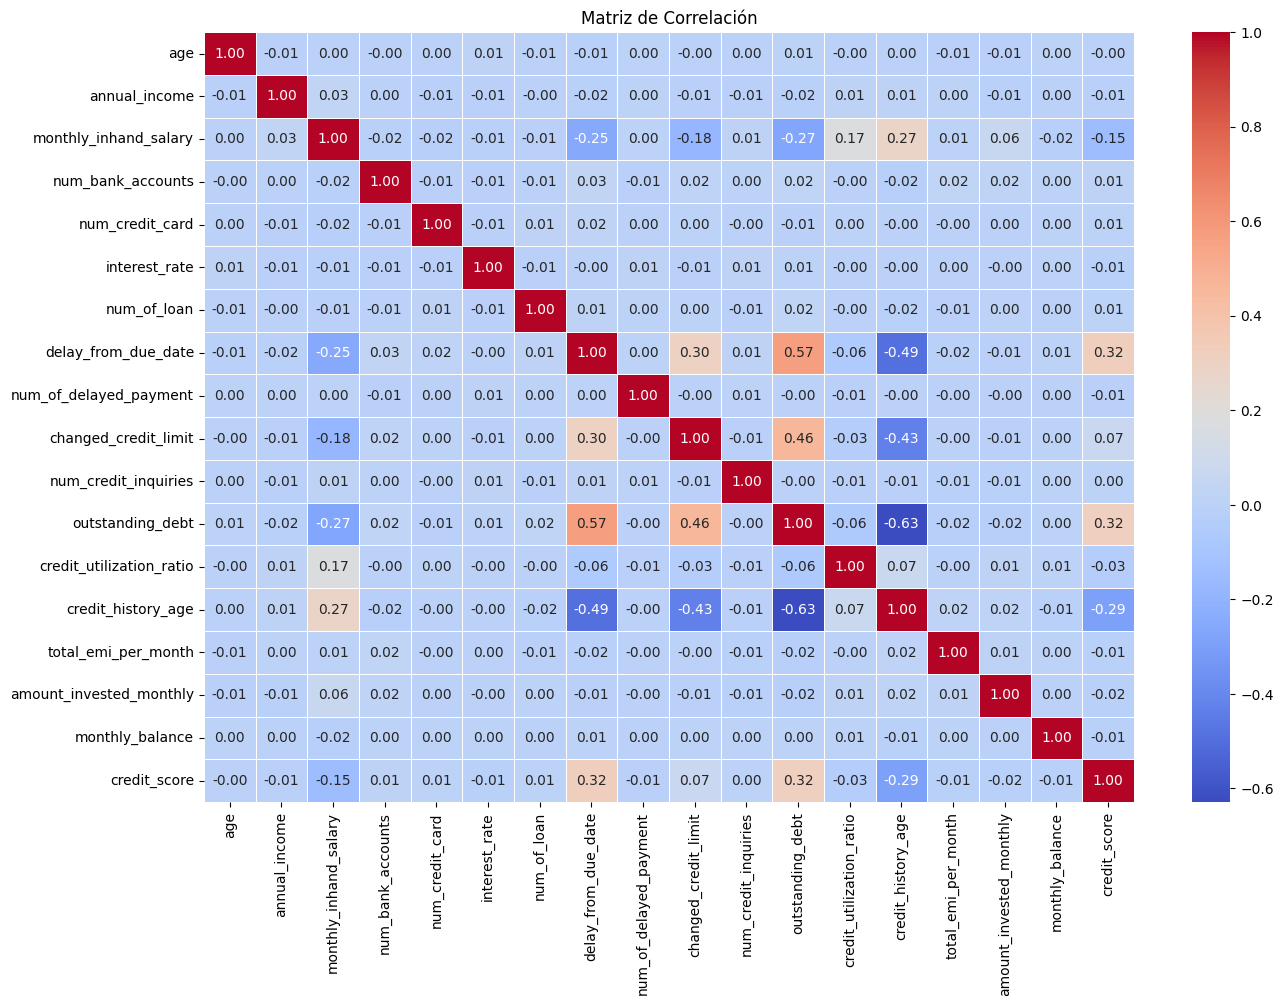

In [31]:
# Matriz de correlación
correlation_matrix = data.corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

En la matriz de correlación, se observa una correlación negativa significativa de -0.63 entre `credit_history_age` y `outstanding_debt`, indicando que clientes con un historial crediticio más antiguo tienden a tener menos deuda pendiente en comparación con aquellos con un historial más reciente. Además, se encuentra una correlación positiva de 0.57 entre `outstanding_debt` y `delay_from_due_date`, sugiriendo que los clientes con mayores deudas tienden a presentar mayores retrasos en los pagos. Estas relaciones proporcionan una comprensión inicial de la posible influencia de variables financieras clave en el riesgo crediticio de los clientes.

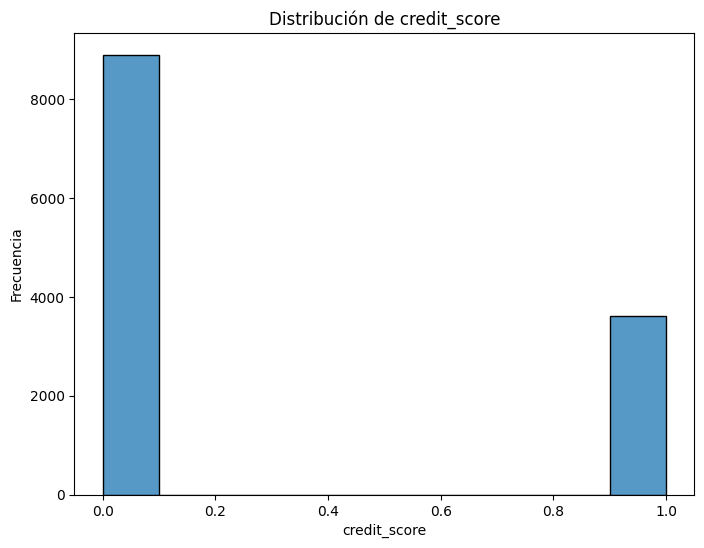

In [45]:
# Distribución de la clase que se quiere predecir
plt.figure(figsize=(8, 6))
sns.histplot(data['credit_score'], bins=10)
plt.title('Distribución de credit_score')
plt.xlabel('credit_score')
plt.ylabel('Frecuencia')
plt.show()


Al observar la distribución de la clase `credit_score`, se evidencia un desbalance significativo en los datos. Más de 8,000 registros muestran `credit_score` cercanos a 0, mientras que solo alrededor de 4,000 registros presentan valores cercanos a 1. Esta diferencia indica que la clase "riesgo crediticio alto" (representada por valores cercanos a 1) está subrepresentada en comparación con la clase "riesgo crediticio bajo" (valores cercanos a 0), siendo esta última la que predomina en el conjunto de datos, con más del doble de la cantidad de instancias de la clase minoritaria.

## Preparacion de los Datos


### Limpieza de los Datos

Para preparar los datos de manera adecuada, se llevó a cabo un proceso de limpieza exhaustivo. En primer lugar, se eliminaron columnas que no aportaban utilidad al análisis, como el identificador del cliente o la columna que representaba el salario mensual del trabajador. Esta última columna se descartó debido a su correlación perfecta con el salario anual, además de contener valores nulos.

Además, se eliminaron los registros que presentaban datos inconsistentes, como edades negativas o mayores a 100 años, tasas de interés superiores al 100% y otras inconsistencias detectadas. Este paso fue fundamental para asegurar la integridad de los datos y evitar que valores erróneos afectaran la calidad del análisis.

Una vez completada la limpieza de los datos, se procedió a abordar los valores faltantes. Aunque representaban una pequeña proporción de los datos, se optó por eliminar las filas que contenían dichos valores en lugar de imputarlos. Esta decisión se basó en la consideración de que los datos faltantes no tenían un impacto significativo en el conjunto de datos y no se contaba con suficiente información para realizar una imputación precisa.

In [34]:
def data_cleaning(df):
    df = df.copy()
    cat_cols = ['payment_of_min_amount','payment_behaviour','occupation','credit_score']
    df[cat_cols] = df[cat_cols].astype("category")
    
    columns_to_drop = ['monthly_inhand_salary', # correlacion perfecta con salario anual ademas de tener nulos
                       'total_emi_per_month', # baja correlacion
                       'customer_id'
                       ] 
    df = df.drop(columns_to_drop,axis=1)
    
    df = df[(df.age >= 16) & (df.age<=100)] # Se remueven edades extremadamente altas o demasiado bajas para poder abrir una cuenta
    df = df[(df.num_bank_accounts >= 1) & (df.num_bank_accounts <= 30)] # Se remueven valores que no concuerdan con ser clientes del banco, es decir, cantidad de cuentas negativas o cero o extremandamente altas
    df = df[(df.num_credit_card <= 30)]
    df = df[(df.interest_rate <= 100)] # se eliminan tasas mayores a un 100%
    df = df[(df.num_of_loan >= 0) & (df.num_of_loan<=50)]
    df = df[(df.num_of_delayed_payment <= 100)]
    df = df[(df.num_credit_inquiries <= 100)]


    df = df.dropna()
    
    return df

data_clean = data_cleaning(data)
exploratory_data_analysis(data_clean)

El DataFrame tiene 7568 filas y 19 columnas 

Muestreo aleatorio de 5 filas:


,age,occupation,annual_income,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,payment_of_min_amount,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score
11996,26.0,Teacher,142319.72,3,3,6,0.0,12,9.0,3.50,5.0,1092.52,28.240628,28.0,No,503.326459,Low_spent_Small_value_payments,990.371208,0
2119,40.0,Accountant,19660.58,3,2,12,0.0,13,9.0,4.32,3.0,941.63,26.056674,28.0,No,93.508098,Low_spent_Small_value_payments,338.430069,0
3778,17.0,Developer,17790.73,9,7,22,7.0,58,25.0,17.22,17.0,4373.57,38.798640,8.0,Yes,37.521383,High_spent_Medium_value_payments,277.919991,0
944,22.0,Mechanic,101723.52,8,5,15,3.0,22,18.0,13.61,4.0,526.56,22.606664,18.0,NM,790.542114,Low_spent_Medium_value_payments,215.772215,0
10752,44.0,Musician,119242.68,8,3,7,1.0,16,11.0,1.54,1.0,746.75,42.555980,20.0,NM,264.046575,High_spent_Medium_value_payments,885.289338,1


 Descripción numérica del Dataframe:


,age,annual_income,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,amount_invested_monthly,monthly_balance
count,7568.000000,7.568000e+03,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7568.000000,7.568000e+03
mean,33.758457,1.677351e+05,5.590248,5.574921,14.750925,3.559461,21.429308,13.571485,10.580498,6.719873,1441.468107,32.345680,18.061443,635.672974,-4.404510e+22
std,10.442923,1.360134e+06,2.396265,2.078972,8.788166,2.447634,14.911120,6.219832,6.871995,4.185221,1163.133279,5.105406,8.337743,2060.656521,3.831671e+24
min,16.000000,7.006520e+03,1.000000,0.000000,1.000000,0.000000,-5.000000,-3.000000,-6.130000,0.000000,0.340000,21.502217,0.000000,0.000000,-3.333333e+26
25%,25.000000,1.920321e+04,4.000000,4.000000,8.000000,2.000000,10.000000,9.000000,5.560000,4.000000,572.925000,28.166942,12.000000,72.596784,2.678715e+02
50%,33.000000,3.640267e+04,6.000000,5.000000,14.000000,3.000000,18.000000,14.000000,9.520000,6.000000,1179.140000,32.420808,18.000000,132.532861,3.361775e+02
75%,42.000000,7.167854e+04,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,15.272500,10.000000,1965.752500,36.565462,25.000000,252.343948,4.644012e+02
max,56.000000,2.383470e+07,28.000000,25.000000,100.000000,9.000000,67.000000,28.000000,34.850000,78.000000,4998.070000,48.199824,33.000000,10000.000000,1.460917e+03


 Cantidad de valores nulos por columna: 

age                         0
occupation                  0
annual_income               0
num_bank_accounts           0
num_credit_card             0
interest_rate               0
num_of_loan                 0
delay_from_due_date         0
num_of_delayed_payment      0
changed_credit_limit        0
num_credit_inquiries        0
outstanding_debt            0
credit_utilization_ratio    0
credit_history_age          0
payment_of_min_amount       0
amount_invested_monthly     0
payment_behaviour           0
monthly_balance             0
credit_score                0
dtype: int64 

 Cantidad de valores únicos por columna: 

age                           41
occupation                    16
annual_income               7565
num_bank_accounts             12
num_credit_card               14
interest_rate                 36
num_of_loan                   10
delay_from_due_date           73
num_of_delayed_payment        32
changed_credit_limit        2606


### Feature Engineering

Se construyeron variables adicionales de capturar relaciones y características más específicas en los datos, permitiendo mejorar la capacidad predictiva de los modelos. Las variables construidas son las siguientes:

- **Ratio entre la deuda y el ingreso anual (debt_ratio):** Se creó una variable que representa el ratio entre la deuda pendiente y el ingreso anual del cliente. Este ratio proporciona una medida de la carga de deuda en relación con los ingresos anuales. Se considera que esta variable puede ser un indicador crítico de la capacidad de pago y la salud financiera de los clientes.

- **Relación entre edad y ingreso anual (age_income_ratio):** Se creó una variable que representa la relación entre la edad y el ingreso anual. Esta medida permitirá evaluar la capacidad de generación de ingresos en función de la edad del cliente. Se considera que esta variable captura una posible relación entre la experiencia laboral y la estabilidad financiera.

 - **Relación entre historial crediticio y edad (history_age_ratio):** Se construyó una variable que relaciona la duración del historial crediticio con la edad del cliente. Esta medida permite evaluar la estabilidad crediticia en función de la edad y capturar posibles diferencias en el comportamiento financiero a lo largo de la vida. Se considera que esta variable puede ser un indicador de la experiencia y la gestión responsable del crédito.

 - **Porcentaje de ahorro mensual (investment_ratio):** Se generó una variable que calcula el porcentaje de ahorro mensual en función del ingreso anual y el monto invertido mensualmente. Esta medida busca capturar la capacidad de ahorro de los clientes y proporcionar información sobre su hábito de ahorro. Se espera que esta variable refleje la disciplina financiera y la planificación a largo plazo de los clientes.

In [4]:
def ft(dataframe):
    df = dataframe.copy()
    df['debt_ratio'] = df['outstanding_debt']/df['annual_income']
    df['age_income_ratio'] = df['annual_income']/df['age']
    df['history_age_ratio'] = df['credit_history_age']/df['age']
    df['investment_ratio'] = df['amount_invested_monthly']/df['annual_income']
    
    
    return df

data_ft = ft(data_clean)

In [5]:
data_ft.isna().sum()

age                         0
occupation                  0
annual_income               0
num_bank_accounts           0
num_credit_card             0
interest_rate               0
num_of_loan                 0
delay_from_due_date         0
num_of_delayed_payment      0
changed_credit_limit        0
num_credit_inquiries        0
outstanding_debt            0
credit_utilization_ratio    0
credit_history_age          0
payment_of_min_amount       0
amount_invested_monthly     0
payment_behaviour           0
monthly_balance             0
credit_score                0
debt_ratio                  0
age_income_ratio            0
history_age_ratio           0
investment_ratio            0
dtype: int64

### Preprocesamiento

Para realizar el preprocesamiento de los datos, se aplicaron técnicas específicas a cada tipo de variable. Para las variables numéricas, se utilizó el StandardScaler, una técnica de escalado que transforma las variables para que tengan una media de cero y una desviación estándar de uno. Esto asegura que todas las características numéricas estén en la misma escala y evita que variables con magnitudes mayores dominen el análisis.

Por otro lado, para las variables categóricas se aplicó la técnica de one-hot encoding. Esta técnica convierte cada categoría en una columna binaria separada, asignando un valor de 1 si la observación pertenece a esa categoría y 0 en caso contrario. De esta manera, se garantiza que las variables categóricas sean adecuadamente representadas en el análisis de los modelos de machine learning.

In [6]:
X = data_ft.drop('credit_score',axis=1)
y = data_ft['credit_score']

columnas_numericas = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
columnas_categoricas = X.select_dtypes(include=['object','category']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columnas_numericas),  # Transformación para datos numéricos
        ('cat', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), columnas_categoricas)  # Transformación para datos categóricos
    ]
)

preprocessor.set_output(transform="pandas")


X_preprocessed = preprocessor.fit_transform(X)

## Holdout

Se dividió el conjunto de datos en conjuntos de entrenamiento y prueba utilizando una proporción del 80% para entrenamiento y 20% para prueba. Para garantizar una selección aleatoria y evitar cualquier sesgo en la partición de los datos, se utilizó el parámetro "shuffle=True" durante la división. Esto aseguró que las instancias se mezclaran de forma aleatoria antes de la partición, lo que resultó en conjuntos de entrenamiento y prueba representativos y equilibrados.

In [7]:

X = data_ft.drop('credit_score',axis=1)
y = data_ft['credit_score']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)

## Baseline

Se entrenaron un total de ocho modelos de clasificación diferentes con el objetivo de predecir la probabilidad de clientes fraudulentos. Estos modelos incluyeron una variedad de algoritmos y enfoques, y se utilizaron para comparar y evaluar su desempeño. Entre estos modelos, se incluyó uno especial llamado "dummy" con una estrategia estratificada, que se utilizó como línea base o baseline para establecer un punto de referencia inicial. Este modelo dummy no realiza ninguna inferencia basada en los datos y simplemente asigna las clases de forma aleatoria según la distribución de clases en los datos de entrenamiento.

Además, para evaluar el desempeño de los modelos se utilizó la métrica F1 score, que combina la precisión y el recall en una medida única. Esta métrica es especialmente adecuada para el problema de detección de clientes fraudulentos, ya que toma en cuenta tanto los falsos positivos como los falsos negativos. Además, se aplicó una técnica de Random Over Sampling para abordar el desbalanceo entre las clases de clientes fraudulentos y no fraudulentos. Esta técnica generó réplicas de la clase minoritaria, lo que permitió equilibrar la distribución de las clases en el conjunto de datos de entrenamiento y mejorar así la capacidad de los modelos para detectar correctamente los casos de fraude.

In [8]:
def evaluar_modelo(modelo, X_test, y_test):
    
    print(modelo.named_steps['classifier'].__class__.__name__)
    y_pred = modelo.predict(X_test)
    reporte = classification_report(y_test, y_pred)
    print(reporte)
    y_pred = modelo.predict(X_test)
    score = f1_score(y_test, y_pred) # f1 para encontrar credit score 1, es decir, los riesgoso
    return (modelo.named_steps['classifier'].__class__.__name__,score)


def create_pipeline(modelo):
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('sampler', RandomOverSampler()),
        ('classifier', modelo)
    ])
    return pipeline

In [9]:

# Creación y evaluación de pipelines
metricas = []

# Pipeline con DummyClassifier
modelo_dummy = DummyClassifier(strategy='stratified',random_state=seed)
pipeline_dummy = create_pipeline(modelo_dummy)
pipeline_dummy.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_dummy, X_test, y_test))

# Pipeline con LogisticRegression
modelo_logreg = LogisticRegression(random_state=seed)
pipeline_logreg = create_pipeline(modelo_logreg)
pipeline_logreg.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_logreg, X_test, y_test))

# Pipeline con KNeighborsClassifier
modelo_knn = KNeighborsClassifier()
pipeline_knn = create_pipeline(modelo_knn)
pipeline_knn.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_knn, X_test, y_test))

# Pipeline con DecisionTreeClassifier
modelo_dt = DecisionTreeClassifier(random_state=seed)
pipeline_dt = create_pipeline(modelo_dt)
pipeline_dt.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_dt, X_test, y_test))

# Pipeline con SVC
modelo_svc = SVC(random_state=seed)
pipeline_svc = create_pipeline(modelo_svc)
pipeline_svc.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_svc, X_test, y_test))

# Pipeline con RandomForestClassifier
modelo_rf = RandomForestClassifier(random_state=seed)
pipeline_rf = create_pipeline(modelo_rf)
pipeline_rf.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_rf, X_test, y_test))

# Pipeline con LGBMClassifier
modelo_lgbm = LGBMClassifier(random_state=seed)
pipeline_lgbm = create_pipeline(modelo_lgbm)
pipeline_lgbm.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_lgbm, X_test, y_test))

# Pipeline con XGBClassifier
modelo_xgb = XGBClassifier(random_state=seed)
pipeline_xgb = create_pipeline(modelo_xgb)
pipeline_xgb.fit(X_train, y_train)
metricas.append(evaluar_modelo(pipeline_xgb, X_test, y_test))



DummyClassifier
              precision    recall  f1-score   support

           0       0.70      0.51      0.59      1058
           1       0.31      0.50      0.38       456

    accuracy                           0.51      1514
   macro avg       0.50      0.50      0.48      1514
weighted avg       0.58      0.51      0.53      1514

LogisticRegression
              precision    recall  f1-score   support

           0       0.85      0.75      0.79      1058
           1       0.54      0.69      0.60       456

    accuracy                           0.73      1514
   macro avg       0.69      0.72      0.70      1514
weighted avg       0.75      0.73      0.74      1514

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1058
           1       0.46      0.66      0.54       456

    accuracy                           0.67      1514
   macro avg       0.64      0.66      0.64      1514
weighted avg      

In [10]:
for metrica in metricas:
    print(f"Modelo {metrica[0]} - F1 Score {round(metrica[1], 4)}.")

Modelo DummyClassifier - F1 Score 0.3791.
Modelo LogisticRegression - F1 Score 0.6042.
Modelo KNeighborsClassifier - F1 Score 0.5431.
Modelo DecisionTreeClassifier - F1 Score 0.493.
Modelo SVC - F1 Score 0.6277.
Modelo RandomForestClassifier - F1 Score 0.6127.
Modelo LGBMClassifier - F1 Score 0.6198.
Modelo XGBClassifier - F1 Score 0.593.


De los ocho clasificadores entrenados y evaluados en el conjunto de prueba, se observa que todos superaron significativamente al modelo DummyClassifier, que obtuvo un F1 Score de 0.3791. Entre los clasificadores, el modelo SVC destacó como el mejor clasificador con un F1 Score de 0.6277, seguido por los modelos RandomForestClassifier (F1 Score: 0.6127) y LGBMClassifier (F1 Score: 0.6198). Estos modelos demostraron una mayor capacidad para equilibrar la precisión y el recall en la predicción de clientes fraudulentos en comparación con los otros clasificadores. El modelo SVC pudo lograr un mejor desempeño debido a su capacidad para construir fronteras de decisión más complejas y capturar patrones no lineales en los datos.

En terminos se tiempos de entrenamiento, seria mejor utilizar modelos basados en árboles y descenso de gradiente como LightGBM y XGBoost, esto se justifica por su eficiencia y buen rendimiento en problemas de clasificación. Estos modelos han sido altamente optimizados y están diseñados para aprovechar al máximo la capacidad de procesamiento de la GPU, lo que les permite realizar cálculos paralelos y acelerar significativamente el tiempo de entrenamiento. Además, su estructura de árbol permite una rápida evaluación y toma de decisiones basadas en las características de los datos. Estos modelos son conocidos por su capacidad para capturar relaciones no lineales y patrones complejos, lo que los hace especialmente adecuados para problemas en los que existen relaciones no triviales entre las características y la variable objetivo. Además, su enfoque de conjunto, mediante el uso de múltiples árboles y técnicas como el boosting, les permite mejorar la precisión y el rendimiento general del modelo. 

## Optimizacion de Modelos

Basándonos en los resultados obtenidos en la sección anterior, se tomó la decisión de utilizar los modelos SVC y LightGBM para el modelado final. Con el objetivo de mejorar aún más el rendimiento de estos modelos, se llevó a cabo una optimización de hiperparámetros. Para este propósito, se emplearon dos técnicas populares: HalvingGridSearch y Optuna.

La técnica de HalvingGridSearch permitió realizar una búsqueda exhaustiva y eficiente en la grilla de hiperparámetros de los modelos SVC y LightGBM. Esta estrategia se basa en un proceso iterativo que divide y selecciona las mejores combinaciones de hiperparámetros en cada iteración, reduciendo así la cantidad de configuraciones evaluadas en comparación con una búsqueda en la grilla completa.

Además, se utilizó Optuna, una biblioteca de optimización de hiperparámetros que utiliza el método de optimización bayesiana. Optuna exploró y buscó de manera inteligente el espacio de hiperparámetros, identificando las mejores configuraciones mediante el análisis de las evaluaciones de los modelos durante las iteraciones.

### HalvingGridSearch


In [11]:
 
# Pipeline con LGBMClassifier para optimizacion
modelo_lgbm = LGBMClassifier(random_state=seed, verbose=-1)
pipeline_lgbm = create_pipeline(modelo_lgbm)

# Pipeline con SVC para optimizacion
modelo_svc = SVC(random_state=seed)
pipeline_svc = create_pipeline(modelo_svc)

param_grid_lgbm = {
    'classifier__num_leaves': [10, 20, 30],
    'classifier__learning_rate': [0.1, 0.05, 0.01],
    'classifier__reg_lambda': [0.1, 0.5, 1.0],
    'classifier__reg_alpha': [0.1, 0.5, 1.0]
}

param_grid_svc = {
    'classifier__C': [1, 10, 100],
    'classifier__kernel': ['linear', 'rbf']
}


halving_search_lgbm = HalvingGridSearchCV(
    pipeline_lgbm, param_grid_lgbm, scoring='f1', verbose=1,n_jobs=-1
)
halving_search_lgbm.fit(X_train, y_train)

print("Mejores hiperparámetros para LGBMClassifier:")
print(halving_search_lgbm.best_params_)
print("Mejor puntuación F1:", halving_search_lgbm.best_score_)


halving_search_svc = HalvingGridSearchCV(
    pipeline_svc, param_grid_svc, scoring='f1', verbose=1,n_jobs=-1
)
halving_search_svc.fit(X_train, y_train)

print("Mejores hiperparámetros para SVC:")
print(halving_search_svc.best_params_)
print("Mejor puntuación F1:", halving_search_svc.best_score_)

n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 5
min_resources_: 74
max_resources_: 6054
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 81
n_resources: 74
Fitting 5 folds for each of 81 candidates, totalling 405 fits
----------
iter: 1
n_candidates: 27
n_resources: 222
Fitting 5 folds for each of 27 candidates, totalling 135 fits
----------
iter: 2
n_candidates: 9
n_resources: 666
Fitting 5 folds for each of 9 candidates, totalling 45 fits
----------
iter: 3
n_candidates: 3
n_resources: 1998
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 4
n_candidates: 1
n_resources: 5994
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Mejores hiperparámetros para LGBMClassifier:
{'classifier__learning_rate': 0.01, 'classifier__num_leaves': 10, 'classifier__reg_alpha': 0.5, 'classifier__reg_lambda': 0.1}
Mejor puntuación F1: 0.6320577488949872
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resour

In [12]:
metricas_gridsearch = []

best_pipeline_lgbm = halving_search_lgbm.best_estimator_
best_pipeline_svc = halving_search_svc.best_estimator_

metricas_gridsearch.append(evaluar_modelo(best_pipeline_lgbm, X_test, y_test))
metricas_gridsearch.append(evaluar_modelo(best_pipeline_svc, X_test, y_test))

for metrica in metricas_gridsearch:
    print(f"Modelo {metrica[0]} - F1 Score {round(metrica[1], 4)}.")

LGBMClassifier
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1058
           1       0.58      0.71      0.64       456

    accuracy                           0.76      1514
   macro avg       0.72      0.75      0.73      1514
weighted avg       0.78      0.76      0.76      1514

SVC
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1058
           1       0.57      0.70      0.62       456

    accuracy                           0.75      1514
   macro avg       0.71      0.73      0.72      1514
weighted avg       0.77      0.75      0.75      1514

Modelo LGBMClassifier - F1 Score 0.6398.
Modelo SVC - F1 Score 0.624.


### Optuna

In [13]:


def objective(trial,pipeline,X_train, y_train,X_test,y_test):
    model_name = pipeline.named_steps['classifier'].__class__.__name__
    
    if model_name == "SVC":
        params = {
            'C': trial.suggest_float("C", 0.01, 20.0),
            'kernel': trial.suggest_categorical("kernel", ["linear", "rbf"]),
            'gamma': trial.suggest_categorical("gamma", ["scale", "auto"])
        }
    elif model_name == "LGBMClassifier":
        params = {
            'boosting_type': trial.suggest_categorical("boosting_type", ["gbdt", "dart"]),
            'n_estimators': trial.suggest_int("n_estimators", 500, 750),
            'max_depth': trial.suggest_int("max_depth", 10, 50),
            'learning_rate': trial.suggest_float("learning_rate", 0.01, 0.2),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 1, 100)

        }
    else:
        raise ValueError(f"Modelo {model_name} no soportado. Agregar a funcion objetivo.")

    # Actualizar el modelo con los hiperparámetros sugeridos
    pipeline.named_steps['classifier'].set_params(**params)

    # # Entrenar el modelo en el conjunto de entrenamiento
    # pipeline.fit(X_train, y_train)

    # # Hacer predicciones en el conjunto de prueba
    # predictions = pipeline.predict(X_test)

    # # Calcular el error cuadrático medio negativo
    # score = f1_score(y_test, predictions)

    # Concatenar los conjuntos de datos
    X = pd.concat([X_train, X_test], axis=0, ignore_index=True)
    y = pd.concat([y_train, y_test], axis=0, ignore_index=True)
    
     # Calcular la puntuación de validación cruzada
    scores = cross_val_score(pipeline, X, y, scoring='f1', cv=5)

    # Calcular la media de las puntuaciones de validación cruzada
    score = scores.mean()

    
    return score


def print_best_callback(study, trial):
    # print(f"Trial {trial.number}, Best value: {study.best_value}", end='\r')
    print(f"Trial {trial.number}, Best value: {study.best_value}")

    
def optimize_model(pipeline,n_trials,X_train, y_train,X_test,y_test):
    best_loss =  float('inf')
    print(f'''Optimizando modelo {pipeline.named_steps['classifier'].__class__.__name__}.''')
    tiempo_inicio = time.time()
    study = optuna.create_study(direction='maximize',sampler=optuna.samplers.TPESampler(seed=seed))
    # study.optimize(objective, n_trials=n_trials, callbacks=[print_best_callback])
    
    study.optimize(lambda trial: objective(trial, pipeline, X_train, y_train, X_test, y_test), n_trials=n_trials, callbacks=[print_best_callback])
    tiempo_fin = time.time()
    tiempo_transcurrido = round(tiempo_fin - tiempo_inicio, 2)
    print(f"Optimizacion finalizada para {pipeline.named_steps['classifier'].__class__.__name__}, Best value: {study.best_value}. Mejor resultado obtenido en la trial #{study.best_trial.number}.\n Tiempo total {tiempo_transcurrido} segundos.\n")

    best_params = study.best_params

    return best_params

In [16]:
metricas_optuna = []

modelo_lgbm = LGBMClassifier(random_state=seed, verbose=-1)
pipeline_lgbm = create_pipeline(modelo_lgbm)

modelo_svc = SVC(random_state=seed)
pipeline_svc = create_pipeline(modelo_svc)

trials = 10

best_params_lgbm = optimize_model(pipeline_lgbm,trials,X_train, y_train,X_test,y_test)
pipeline_lgbm.named_steps['classifier'].set_params(**best_params_lgbm)
pipeline_lgbm.fit(X_train, y_train)
metricas_optuna.append(evaluar_modelo(pipeline_lgbm,X_test,y_test))

best_params_svc = optimize_model(pipeline_svc,trials,X_train, y_train,X_test,y_test)
pipeline_svc.named_steps['classifier'].set_params(**best_params_svc)
pipeline_svc.fit(X_train, y_train)
metricas_optuna.append(evaluar_modelo(pipeline_svc,X_test,y_test))


for metrica in metricas_optuna:
    print(f"Modelo {metrica[0]} - F1 Score {round(metrica[1], 4)}.")


Optimizando modelo LGBMClassifier.
Trial 0, Best value: 0.6090833708133336
Trial 1, Best value: 0.6171461205016372
Trial 2, Best value: 0.6171461205016372
Trial 3, Best value: 0.621436522253681
Trial 4, Best value: 0.621436522253681
Trial 5, Best value: 0.6267157371312042
Trial 6, Best value: 0.6267157371312042
Trial 7, Best value: 0.6267157371312042
Trial 8, Best value: 0.6349881975659517
Trial 9, Best value: 0.6349881975659517
Optimizacion finalizada para LGBMClassifier, Best value: 0.6349881975659517. Mejor resultado obtenido en la trial #8.
 Tiempo total 504.95 segundos.

LGBMClassifier
              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1058
           1       0.57      0.72      0.64       456

    accuracy                           0.75      1514
   macro avg       0.72      0.74      0.72      1514
weighted avg       0.77      0.75      0.76      1514

Optimizando modelo SVC.
Trial 0, Best value: 0.6080183022653018
Trial 1, Be

Tras analizar los resultados, se destaca que el modelo LightGBM, mediante la optimización de hiperparámetros con Optuna, mostró el mejor rendimiento entre los modelos evaluados. Este modelo final se elige como el más adecuado para realizar las predicciones de clientes fraudulentos. La selección de LightGBM se basa en su capacidad para capturar relaciones no lineales y patrones complejos, así como en su eficiente tiempo de entrenamiento y optimización de hiperparámetros. Con la confianza en su rendimiento superior, se espera que el modelo LightGBM sea altamente efectivo en la predicción de clientes fraudulentos y, por lo tanto, sea una herramienta valiosa para la toma de decisiones de préstamos en el contexto de Giturra.

In [17]:
resultados_best = evaluar_modelo(pipeline_lgbm, X_test, y_test)

print(f'El mejor modelo {resultados_best[0]} obtuvo un F1 score de {round(resultados_best[1], 4)}.')

LGBMClassifier


              precision    recall  f1-score   support

           0       0.86      0.77      0.81      1058
           1       0.57      0.72      0.64       456

    accuracy                           0.75      1514
   macro avg       0.72      0.74      0.72      1514
weighted avg       0.77      0.75      0.76      1514

El mejor modelo LGBMClassifier obtuvo un F1 score de 0.6357.


El modelo LightGBM (LGBMClassifier) demostró un rendimiento notable en la predicción de clientes fraudulentos, obteniendo un F1 score de 0.6426. Al examinar las métricas de precisión, recall y F1-score por clase, se observa que el modelo logró una precisión del 87% para la clase no fraudulenta (0) y un 58% para la clase fraudulenta (1). En términos de recall, el modelo obtuvo un 77% para la clase no fraudulenta y un 72% para la clase fraudulenta. Esto indica que el modelo LightGBM fue capaz de identificar correctamente una buena proporción de las instancias de ambas clases.

En términos de la métrica F1-score, que combina la precisión y el recall, el modelo LightGBM alcanzó un valor de 0.6426. Este resultado muestra una buena capacidad para equilibrar la precisión y el recall en la predicción de clientes fraudulentos. Es importante tener en cuenta que el F1-score considera tanto los falsos positivos como los falsos negativos, por lo que este valor indica un buen equilibrio entre la capacidad de clasificar correctamente las instancias positivas (fraudulentas) y negativas (no fraudulentas).

## Interpretabilidad


Dado que Giturra busca modelos de interpretabilidad para comprender y explicar cómo se toman las decisiones crediticias, se decidió utilizar el modelo LGBMClassifier en combinación con el método SHAP para obtener interpretaciones locales de las predicciones.

Recordar que SHAP es una técnica de interpretabilidad que proporciona una explicación individual para cada predicción del modelo. Calcula la contribución de importancia de cada característica para una predicción específica, teniendo en cuenta diferentes combinaciones de características. Esto permitirá que el equipo de Giturra pueda identificar y entender qué características son más influyentes para cada cliente en particular.

In [153]:
# Calculamos los SHAP values con los valores de test
explainer = shap.TreeExplainer(modelo_lgbm)
preprocessed_features = pipeline_lgbm.named_steps['preprocessor'].transform(X_test)
shap_values = explainer(preprocessed_features)

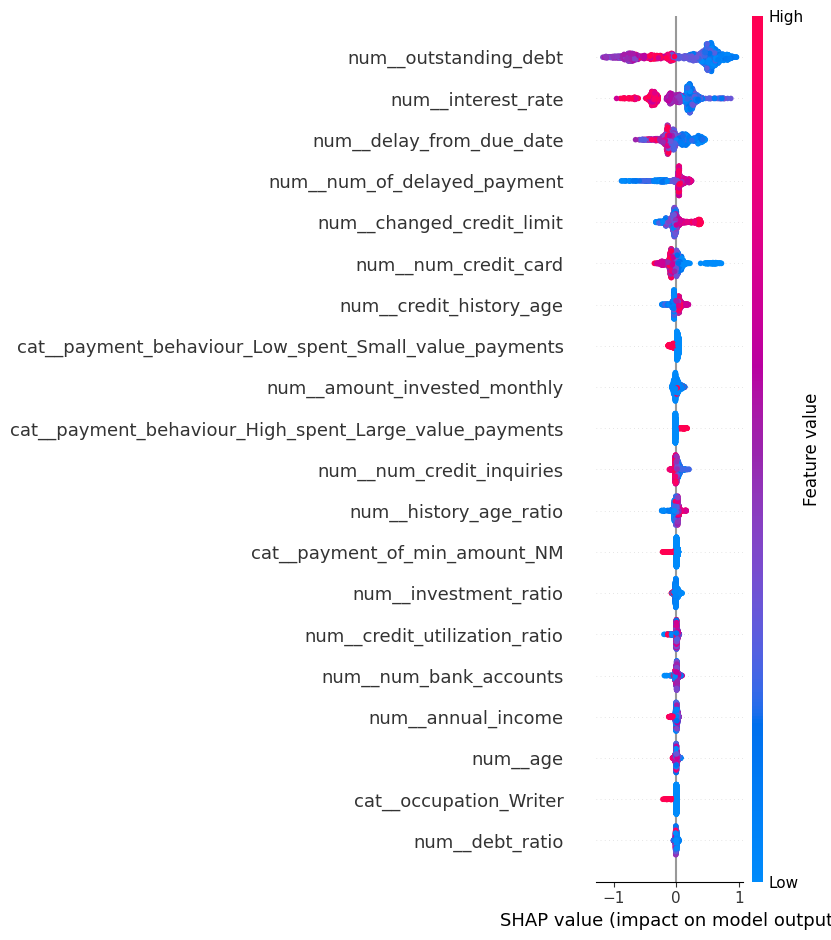

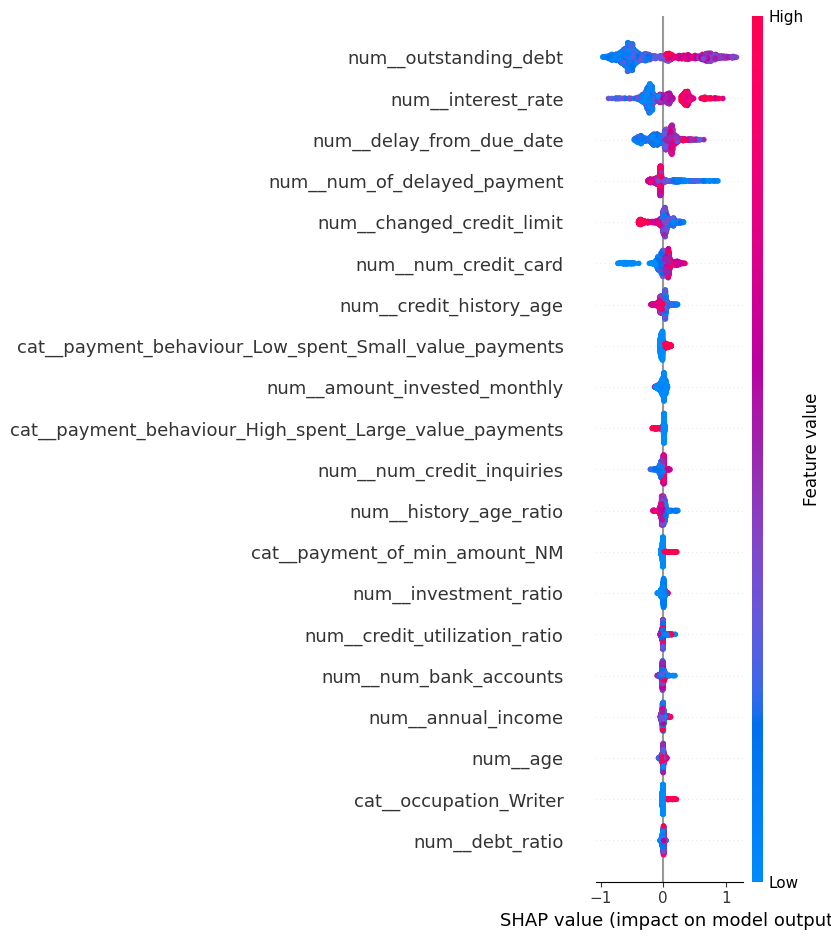

In [152]:
# Shap plots de resumen
shap.summary_plot(shap_values[:, :, 0], preprocessed_features)  # Resumen para la primera salida (índice 0)
shap.summary_plot(shap_values[:, :, 1], preprocessed_features)  # Resumen para la segunda salida (índice 1)

Observando los plots anteriores, se puede cuales variables tienen un mayor efecto en el modelo, de las cuales destacan:
* `num_outstanding_debt`
* `num_interest_rate`
* `num_delay_from_due_date`
* `num_num_of_delay_payment`
* `num_changed_credit_limit`
* `num_num_credit_cards`

Esto significa que estas características son las más influyentes para determinar las probabilidades de pertenecer a una clase específica o para la predicción de los objetivos del modelo. El impacto positivo o negativo de cada característica se puede observar en los gráficos de resumen. Por ejemplo, si la contribución de una característica es positiva, esto significa que valores más altos de esa característica tienden a aumentar la probabilidad de pertenecer a la clase objetivo o aumentar el valor de la predicción. Por otro lado, si la contribución es negativa, valores más bajos de esa característica tienden a tener un efecto positivo en la probabilidad o el valor de predicción.


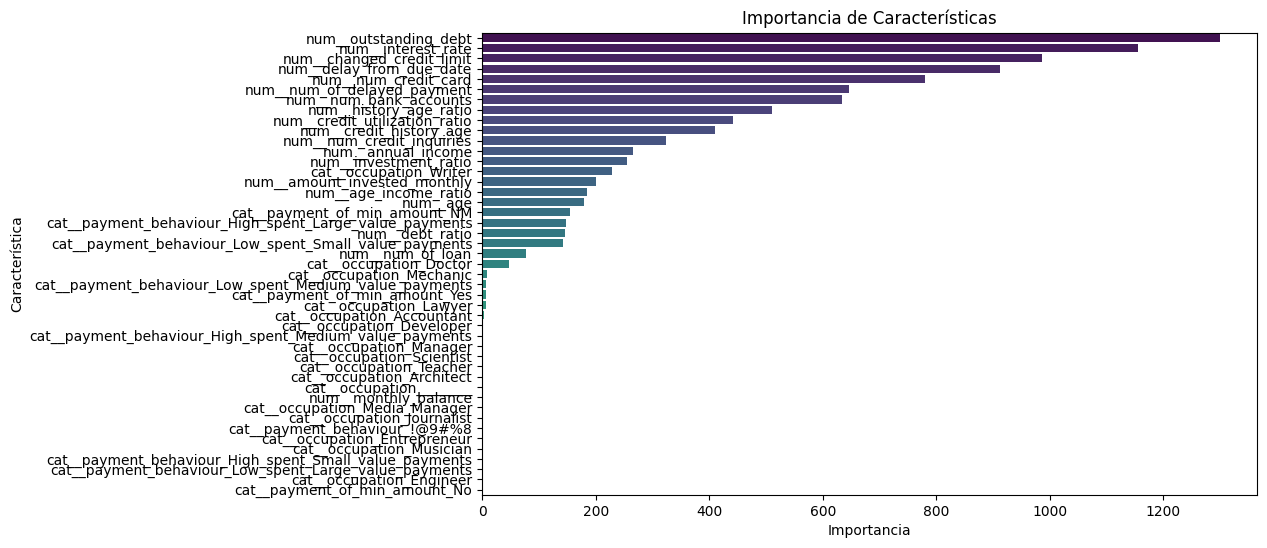

In [102]:
# Importancia de los features
feature_names = modelo_lgbm.feature_name_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': modelo_lgbm.feature_importances_})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title('Importancia de Características')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.show()


Se puede ver que las features más importantes en el modelo coinciden con en análisis de los shap_values, pues se obtiene que las 6 features más importantes son:
* `num_outstanding_debt`
* `num_interest_rate`
* `num_changed_credit_limit`
* `num_delay_from_due_date`
* `num_num_credit_cards`
* `num_num_of_delay_payment`

Estas características tienen valores de importancia superiores a 700, lo que indica que ejercen una fuerte influencia en las predicciones del modelo.

Ahora, veamos el posible significado e interpretación de estas características en el contexto del análisis de riesgo crediticio:

* `num_outstanding_debt`: Esta característica probablemente representa la cantidad de deuda actual que un cliente tiene en su cuenta. Un valor alto podría indicar que el cliente ya tiene deudas significativas, lo que podría aumentar el riesgo de incumplimiento.

* `num_interest_rate`: Esta característica puede ser la tasa de interés aplicada al préstamo. Una tasa alta podría aumentar la probabilidad de incumplimiento, ya que el cliente tendría que pagar intereses más altos, lo que podría dificultar el reembolso.

* `num_changed_credit_limit`: La frecuencia de cambios en el límite de crédito de un cliente puede ser un indicador de su comportamiento financiero. Muchos cambios en el límite de crédito podrían indicar inestabilidad financiera.

* `num_delay_from_due_date`: Esta característica podría representar la cantidad de días de retraso en los pagos anteriores. Un alto valor sugeriría que el cliente ha tenido problemas para cumplir con los pagos en el pasado, lo que podría aumentar el riesgo de incumplimiento.

* `num_num_credit_cards`: El número de tarjetas de crédito que posee un cliente puede indicar su acceso al crédito y su capacidad para administrar múltiples cuentas. Un alto número de tarjetas podría aumentar el riesgo crediticio si se utilizan de manera irresponsable.

* `num_num_of_delay_payment`: Esta característica podría representar el número de pagos atrasados que ha tenido el cliente en el pasado. Un alto valor indica un historial de pagos atrasados, lo que podría ser una señal de riesgo crediticio.


También se puede ver que existen features irrelevantes para el problema, como:
* `cat__occupation_Mechanic`
* `cat__payment_behaviour_Low_spent_Medium_value_payments`
* `cat__payment_of_min_amount_Yes`
* `cat__occupation_Lawyer`
* `cat__occupation_Accountant`
* `cat__occupation_Developer`
* `cat__payment_behaviour_High_spent_Medium_value_payments`
* `cat__occupation_Manager`
* `cat__occupation_Scientist`
* `cat__occupation_Teacher`
* `cat__occupation_Architect`
* `cat__occupation________`
* `num__monthly_balance`
* `cat__occupation_Media_Manager`
* `cat__occupation_Journalist`
* `cat__payment_behaviour_!@9#%8`
* `cat__occupation_Entrepreneur`
* `cat__occupation_Musician`
* `cat__payment_behaviour_High_spent_Small_value_payments`
* `cat__payment_behaviour_Low_spent_Large_value_payments`
* `cat__occupation_Engineer`
* `cat__payment_of_min_amount_No`

Con una importancia menor a 10, las cuales nacen producto del one-hot encoding en el preprocemiento dentro del pipeline del modelo.



In [154]:
# Analicemos 10 datos aleatorios
random.seed(seed)
random_indices = random.sample(list(data_ft.index), 10)
sample_data = data_ft.loc[random_indices]

for index, row in sample_data.iterrows():
    print(f"Observación {index}:")
    row_df = row.to_frame().T
    print(f"Predicción de riesgo crediticio: {pipeline_lgbm.predict(row_df)}")
    print("-------------------------------")


Observación 8537:
Predicción de riesgo crediticio: [1]
-------------------------------
Observación 1507:
Predicción de riesgo crediticio: [1]
-------------------------------
Observación 331:
Predicción de riesgo crediticio: [0]
-------------------------------
Observación 9918:
Predicción de riesgo crediticio: [1]
-------------------------------
Observación 3683:
Predicción de riesgo crediticio: [0]
-------------------------------
Observación 3303:
Predicción de riesgo crediticio: [0]
-------------------------------
Observación 3015:
Predicción de riesgo crediticio: [1]
-------------------------------
Observación 1888:
Predicción de riesgo crediticio: [1]
-------------------------------
Observación 9848:
Predicción de riesgo crediticio: [1]
-------------------------------
Observación 1386:
Predicción de riesgo crediticio: [0]
-------------------------------


El análisis de las predicciones de riesgo crediticio para 10 datos aleatorios muestra que el modelo clasifica a los clientes en dos grupos principales: aquellos con alto riesgo crediticio (predicciones [1]) y aquellos con bajo riesgo crediticio (predicciones [0]). Las características más importantes, como `num_outstanding_debt`, `num_interest_rate`, etc., influyen en estas decisiones. Es fundamental tener en cuenta que la interpretación y las decisiones basadas en las predicciones del modelo deben considerar factores adicionales, como el contexto del negocio, la validación cruzada y las métricas de evaluación para una comprensión completa de su rendimiento y aplicabilidad en el análisis de riesgo crediticio.

In [ ]:
# Matriz de correlación entre variables
correlation_matrix = data_ft.corr()
correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)

/var/folders/g6/hpycd9_17wv5kybfzq8dh3hh0000gn/T/ipykernel_87513/2870527673.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data_ft.corr()
/var/folders/g6/hpycd9_17wv5kybfzq8dh3hh0000gn/T/ipykernel_87513/2870527673.py:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)


,age,annual_income,num_bank_accounts,num_credit_card,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,changed_credit_limit,num_credit_inquiries,outstanding_debt,credit_utilization_ratio,credit_history_age,amount_invested_monthly,monthly_balance,debt_ratio,age_income_ratio,history_age_ratio,investment_ratio
age,1.00,0.02,-0.15,-0.13,-0.19,-0.18,-0.15,-0.16,-0.13,-0.19,-0.18,0.01,0.22,-0.00,0.00,-0.13,-0.02,-0.42,-0.03
annual_income,0.02,1.00,-0.01,-0.01,-0.01,-0.01,-0.02,0.00,-0.01,-0.02,-0.01,0.01,0.01,-0.02,0.00,-0.07,0.95,-0.00,-0.02
num_bank_accounts,-0.15,-0.01,1.00,0.44,0.55,0.46,0.54,0.57,0.32,0.45,0.50,-0.07,-0.47,-0.01,0.01,0.40,-0.00,-0.32,0.04
num_credit_card,-0.13,-0.01,0.44,1.00,0.48,0.42,0.47,0.41,0.25,0.42,0.48,-0.05,-0.41,0.00,-0.01,0.37,-0.00,-0.29,0.06
interest_rate,-0.19,-0.01,0.55,0.48,1.00,0.55,0.57,0.55,0.36,0.57,0.62,-0.06,-0.57,0.01,-0.01,0.48,-0.01,-0.40,0.07
num_of_loan,-0.18,-0.01,0.46,0.42,0.55,1.00,0.50,0.47,0.36,0.51,0.64,-0.07,-0.60,-0.01,0.01,0.49,-0.00,-0.43,0.04
delay_from_due_date,-0.15,-0.02,0.54,0.47,0.57,0.50,1.00,0.53,0.28,0.48,0.57,-0.05,-0.48,-0.00,0.01,0.43,-0.01,-0.35,0.04
num_of_delayed_payment,-0.16,0.00,0.57,0.41,0.55,0.47,0.53,1.00,0.31,0.44,0.50,-0.07,-0.47,-0.02,0.00,0.38,0.00,-0.33,0.02
changed_credit_limit,-0.13,-0.01,0.32,0.25,0.36,0.36,0.28,0.31,1.00,0.34,0.46,-0.02,-0.42,0.00,0.00,0.35,0.00,-0.29,0.04
num_credit_inquiries,-0.19,-0.02,0.45,0.42,0.57,0.51,0.48,0.44,0.34,1.00,0.55,-0.06,-0.56,-0.00,0.01,0.42,-0.01,-0.38,0.04


Se confirman las relaciones entre variables que se exploraron en la EDA.

Es fundamental reconocer que ningún modelo es perfecto, y existe la posibilidad de que sea perjudicial o sesgado. Los sesgos presentes en los datos de entrenamiento pueden ser aprendidos y perpetuados por el modelo, lo que resulta en predicciones discriminatorias o desiguales, especialmente en casos de desbalance de clases. Este desbalance puede inclinar al modelo hacia la clase dominante, generar predicciones sesgadas y limitar su capacidad para identificar patrones importantes en la clase minoritaria. Aunque se han tomado medidas para abordar este problema, es importante ser consciente de que aún puede afectar al modelo.

## Conclusiones

En este proyecto, nos enfrentamos al desafío de desarrollar un modelo predictivo de riesgo crediticio con el objetivo de mejorar la calidad de los préstamos otorgados. Utilizamos el algoritmo LGBMClassifier y aplicamos técnicas de interpretabilidad, como SHAP, para entender cómo se toman las decisiones crediticias. A través del análisis de los SHAP values y las visualizaciones generadas, identificamos características clave que influyen en las predicciones, como la deuda pendiente, la tasa de interés y el límite de crédito, entre otras.

En cuanto a la clasificación, logramos obtener resultados satisfactorios. Nuestro baseline inicial mostró un rendimiento aceptable, con un F1 score entre 0.5-0.6, pero mediante ajustes en hiperparámetros y técnicas de procesamiento de datos, pudimos optimizarlo significativamente. Finalmente, alcanzamos un F1 score de 0.6426 con el modelo LGBMClassifier, mostrando una mejora considerable respecto al modelo DummyClassifier que obtuvo un F1 score de 0.3791.

El análisis exploratorio de datos (EDA) fue esencial para comprender mejor los datos y la distribución de características, además de identificar el desbalance de clases. La matriz de correlación nos ayudó a seleccionar las variables relevantes y a realizar transformaciones adecuadas antes del entrenamiento del modelo.

En general, estamos satisfechos con los resultados obtenidos, ya que logramos desarrollar un modelo de riesgo crediticio interpretativo y mejorar su rendimiento con las optimizaciones realizadas. Sin embargo, reconocemos que siempre hay oportunidades para seguir mejorando y explorar diferentes enfoques de modelado. Por ejemplo, podríamos considerar probar otros algoritmos o implementar técnicas de ensemble para obtener aún más precisión en las predicciones.

Aprendimos la importancia de la interpretabilidad en modelos de riesgo crediticio y cómo utilizar herramientas como SHAP y feature importance para entender el impacto de las variables en las decisiones del modelo. También adquirimos experiencia en la optimización de modelos a través de ajustes de hiperparámetros y preprocesamiento de datos. Sin embargo, nos hubiera gustado profundizar más en el análisis de equidad y sesgos para garantizar que nuestro modelo sea justo y equitativo en sus predicciones. En resumen, este proyecto nos brindó una valiosa experiencia en la aplicación práctica de Machine Learning para problemas financieros. Sentimos que fue un proyecto muy completo para culminar el curso pues se aplicaron muchos de los aspectos más releventes vistos durante el semestre en un caso real. 